In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/mie1624/courseProject")  # change the current directory
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/mie1624/courseProject'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

In [3]:
original    = pd.read_csv("clean_kaggle_data_2020.csv")

#original.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,206) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Cleaning

Drop the questions for non-professinal people.

In [4]:
us_ca   = original.loc[(original["Q3"] == "Canada") | (original["Q3"] == "United States of America"), :]
mask    = us_ca.columns.str.contains("_B")
cleaned = us_ca.loc[1:, ~mask].reset_index(drop=True) 

#cleaned.head() # for verification

Drop the columns containing Other and None answers for multiple-nominal choice questions

In [5]:
maskOther   = cleaned.columns.str.contains("OTHER")
maskNone    = np.roll(maskOther, -1)
cleaned     = cleaned.loc[:, ~(maskOther|maskNone)]

#cleaned.loc[cleaned["Q24_Encoded"] == 1, "Q24_buckets"]#.head() # for verification

# 2. Salary distribution across job titles

In [6]:
jobTitles       = cleaned["Q5"].unique()
jobTitles       = np.delete(jobTitles, np.where(jobTitles == "Other"))
salaryBuckets   = sorted(cleaned["Q24_Encoded"].unique())

salaryFreq      = pd.DataFrame(index=jobTitles)
for salary in salaryBuckets:
    maskSalary          = cleaned["Q24_Encoded"] == salary
    salaryFreq[salary]  = cleaned.loc[maskSalary, "Q5"].value_counts().sort_index()#.to_numpy

salaryFreqRatio = salaryFreq.apply(lambda x: x / x.sum(), axis=1)

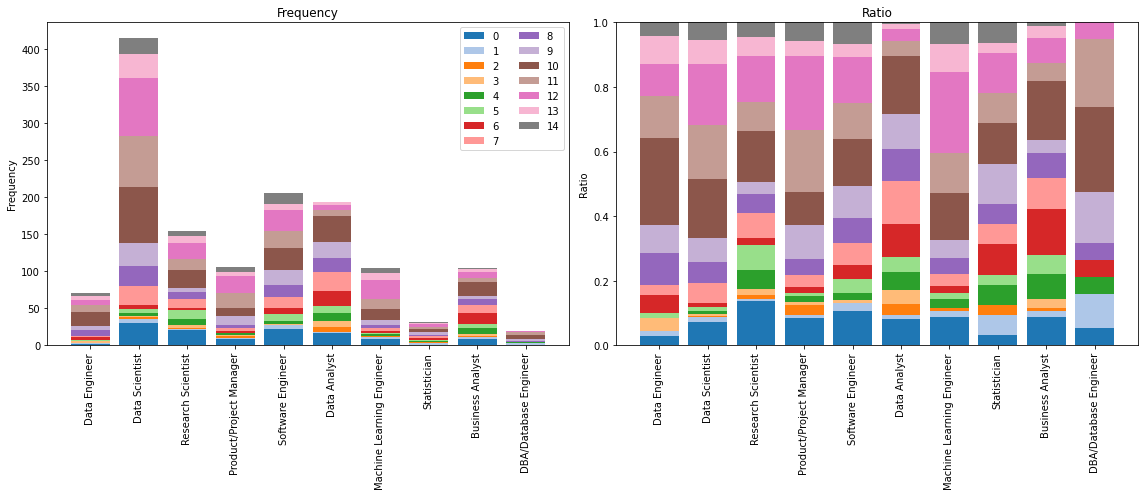

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7), tight_layout=True)
cmap = plt.get_cmap("tab20")

i   = 0 
for title, freq in salaryFreq.iteritems():
    stop    = salaryFreq.columns.get_loc(title)
    # plot the left figure
    ax[0].bar(jobTitles, freq, color=cmap(i), label=int(salaryBuckets[i]), bottom=salaryFreq.iloc[:, 0:stop].sum(axis=1))
    # plot the right figure
    ax[1].bar(jobTitles, salaryFreqRatio[i], color=cmap(i), bottom=salaryFreqRatio.iloc[:, 0:stop].sum(axis=1))
    # add 1 to the counter
    i  += 1

ax[0].set_title("Frequency")
ax[0].set_ylabel("Frequency")
ax[0].tick_params(axis="x", labelrotation= 90)
ax[0].legend(loc="upper right", ncol=2)
ax[1].set_title("Ratio")
ax[1].set_ylabel("Ratio")
ax[1].tick_params(axis="x", labelrotation= 90)

fig.savefig("salaryBarPlotParJobTitle.png")

# 3. Create heatmaps describing the relation between job titles and skills and tools

In [8]:
def createPivotTab(questions):
    df      = pd.DataFrame()#.atype("float32")
    answers = []
    for title in jobTitles:
        mask    = cleaned["Q5"] == title
        counts  = []
        for q in questions.columns:
            if len(answers) < len(questions.columns):
                answers.append(questions[q].value_counts().index[0])
            counts.append(cleaned.loc[mask, q].notna().sum())

        df[title] = counts

    df  = df.set_axis(answers, axis=0)

    return df

In [9]:
def normalizedHeatmap(df, ax=None, saveAs=None):
    scaler  = MinMaxScaler()
    pivot   = createPivotTab(df)
    normalized  = pd.DataFrame(scaler.fit_transform(pivot), columns=pivot.columns, index=pivot.index)
    fig = sns.heatmap(normalized, ax=ax).get_figure()

    if saveAs is not None:
        fig.savefig(saveAs)

In [10]:
def drawHeatMaps(df):
    fig, axes   = plt.subplots(1, 2, tight_layout=True, sharey="row")

    pivot   = createPivotTab(df)
    sns.heatmap(pivot, ax=axes[0], square=True, cbar=False, annot=True, fmt="d").set(title="Frequency")
    normalizedHeatmap(df, axes[1])

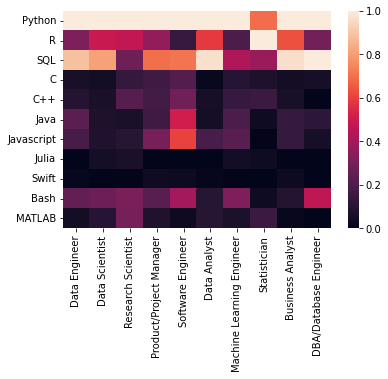

In [11]:
# Q7 What programming languages do you use on a regular basis? (Select all that apply)
normalizedHeatmap(cleaned.filter(like="Q7"), saveAs="07_codeLang.png")

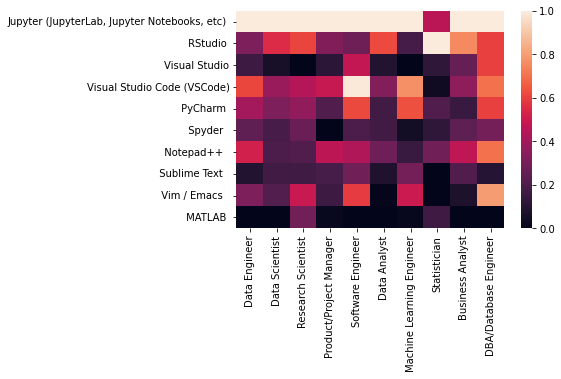

In [12]:
# Q9 Which of the following integrated development environments (IDE's) do you use on a regular basis? (Select all that apply)
normalizedHeatmap(cleaned.filter(like="Q9"), saveAs="09_IDE.png")

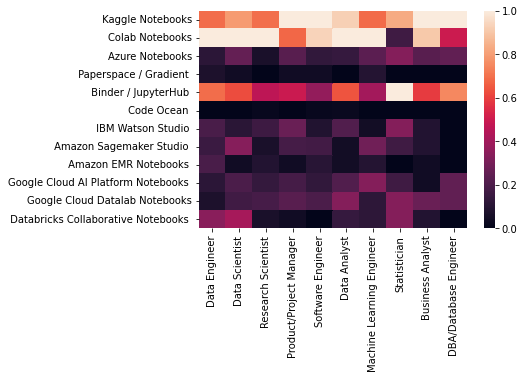

In [13]:
# Q10 Which of the following hosted notebook products do you use on a regular basis?  (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q10"), saveAs="10_notebookProd.png") 

In [14]:
# Q11 What type of computing platform do you use most often for your data science projects?
#normalizedHeatmap(cleaned.filter(like="Q11"), saveAs="11_compPlatform.png") 

In [15]:
# Q12 Which types of specialized hardware do you use on a regular basis?  (Select all that apply) 
#normalizedHeatmap(cleaned.filter(like="Q12"), saveAs="12_specialHardware.png")

In [16]:
# Q13 Approximately how many times have you used a TPU (tensor processing unit)? 
#normalizedHeatmap(cleaned.filter(like="Q13"), saveAs="13_hardwareUsingTime.png")

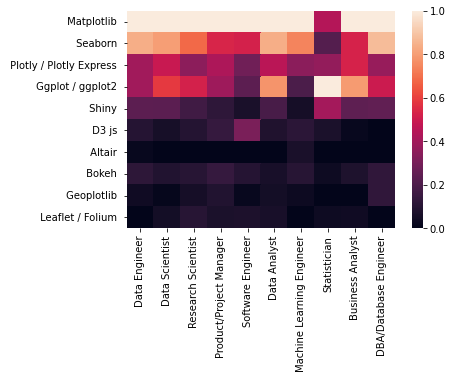

In [17]:
# Q14 What data visualization libraries or tools do you use on a regular basis?  (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q14"), saveAs="14_VisTool.png")

In [18]:
# Q15 For how many years have you used machine learning methods? 
#normalizedHeatmap(cleaned.filter(like="Q15"), saveAs="15_experienceInML.png")

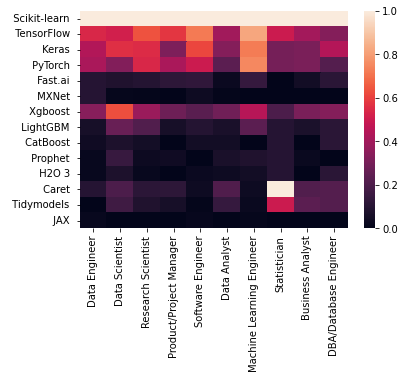

In [19]:
# Q16 Which of the following machine learning frameworks do you use on a regular basis? (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q16"), saveAs="16_MLFramework.png")

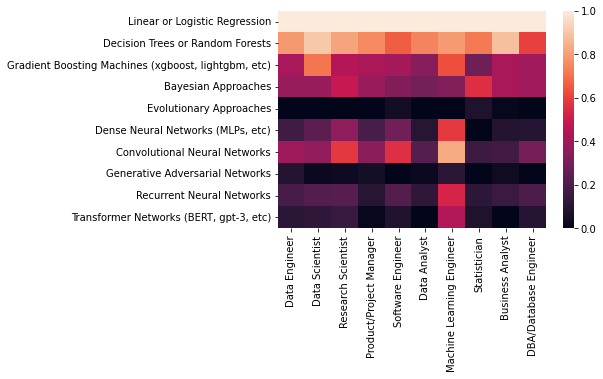

In [20]:
# Q17 Which of the following ML algorithms do you use on a regular basis? (Select all that apply): 
normalizedHeatmap(cleaned.filter(like="Q17"), saveAs="17_MLAlgo.png")

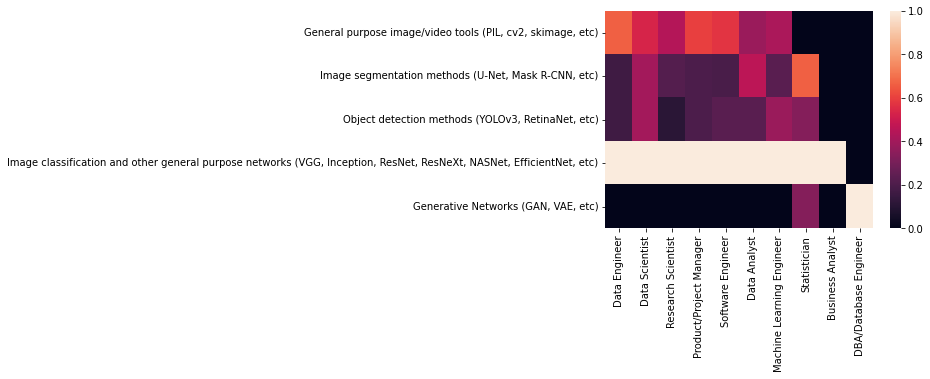

In [21]:
# Q18 Which categories of computer vision methods do you use on a regular basis?  (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q18"), saveAs="18_imgProc.png")

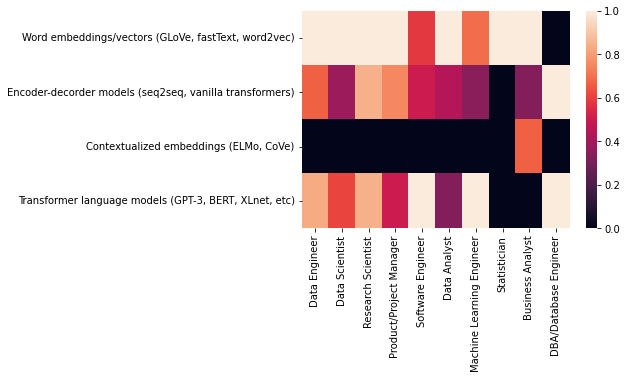

In [22]:
# Q19 Which of the following natural language processing (NLP) methods do you use on a regular basis? (Select all that apply)
normalizedHeatmap(cleaned.filter(like="Q19"), saveAs="19_NLP.png")

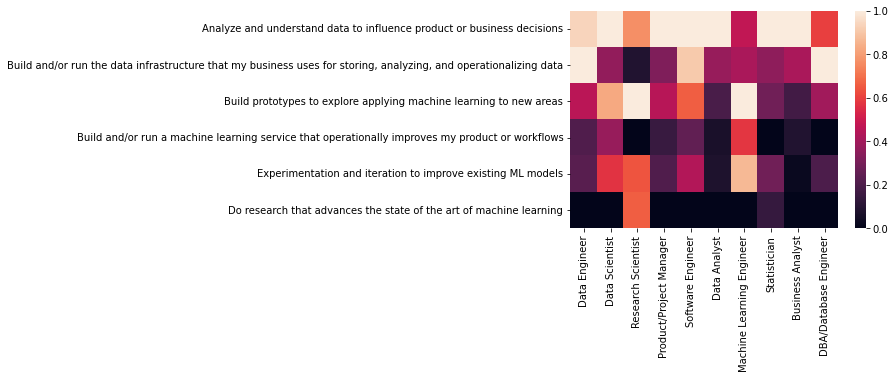

In [23]:
# Q23 Select any activities that make up an important part of your role at work: (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q23"), saveAs="23_taskAtWork.png")

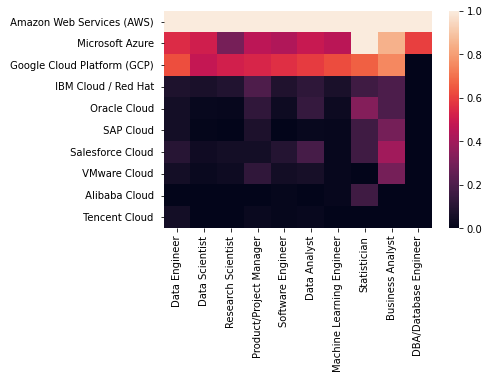

In [24]:
# Q26-A Which of the following cloud computing platforms do you use on a regular basis? (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q26"), saveAs="26_cloudPlatform.png")

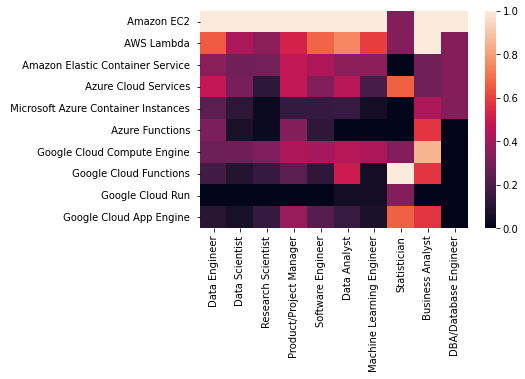

In [25]:
# Q27-A Do you use any of the following cloud computing products on a regular basis? (Select all that apply)
normalizedHeatmap(cleaned.filter(like="Q27"), saveAs="27_cloudCompProd.png") 

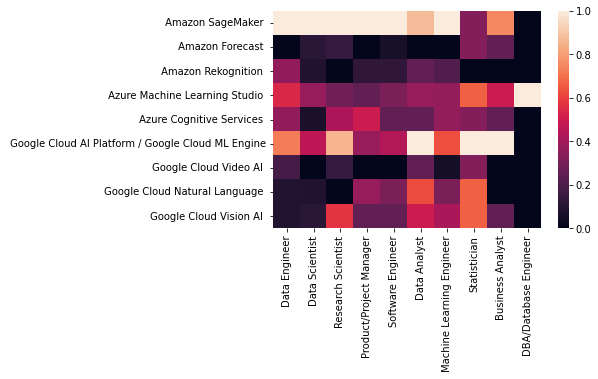

In [26]:
# Q28-A Do you use any of the following machine learning products on a regular basis? (Select all that apply)
normalizedHeatmap(cleaned.filter(like="Q28"), saveAs="28_MLProd.png")

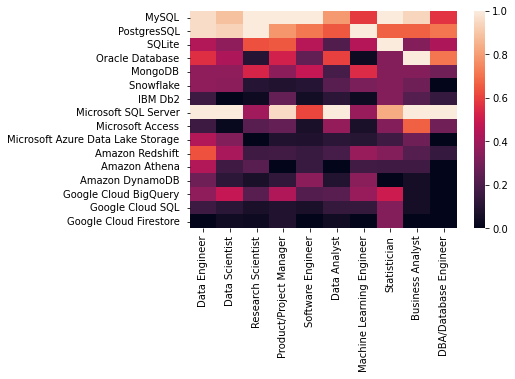

In [27]:
# Q29-A Which of the following big data products (relational databases, data warehouses, data lakes, or similar) do you use on a regular basis? (Select all that apply)  
normalizedHeatmap(cleaned.filter(like="Q29"), saveAs="29_bigDataSvc.png")

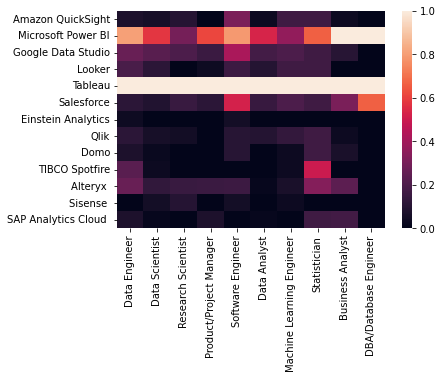

In [28]:
# Q31-A Which of the following business intelligence tools do you use on a regular basis? (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q31"), saveAs="31_bizIntelTool.png") 

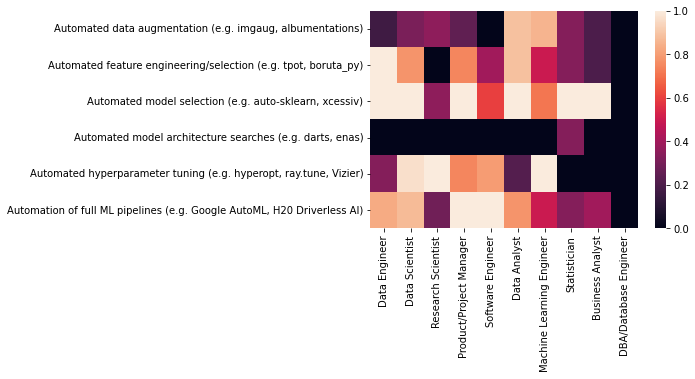

In [29]:
# Q33-A Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q33"), saveAs="33_autoMLLib.png") 

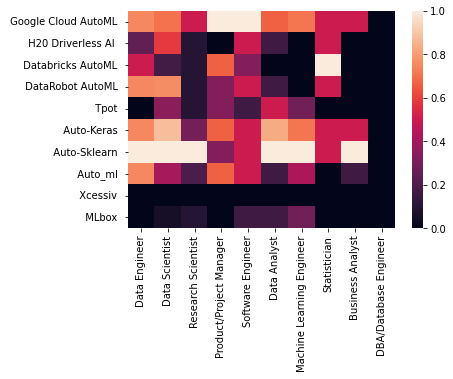

In [30]:
# Q34-A Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis?  (Select all that apply)7 
normalizedHeatmap(cleaned.filter(like="Q34"), saveAs="34_autoMLProd.png") 

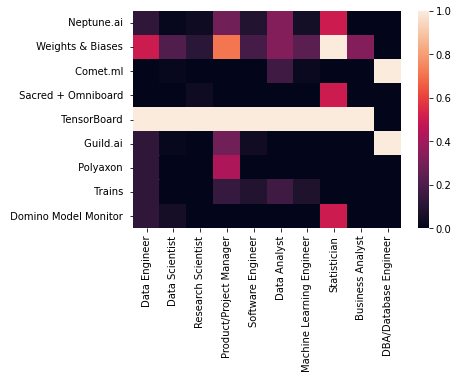

In [31]:
# Q35-A Do you use any tools to help manage machine learning experiments? (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q35"), saveAs="35_MLManager.png") 

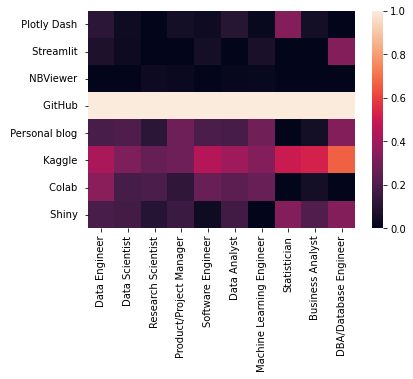

In [32]:
# Q36 Where do you publicly share or deploy your data analysis or machine learning applications? (Select all that apply) 
normalizedHeatmap(cleaned.filter(like="Q36"), saveAs="36_codeSharePlatform.png") 

# 3. Evaluate a statistical significance retrieved from each answer choice of select-all multiple answer choice questions.

In [33]:
targetQuestions = ["Q7", 
#                   "Q8",    # about the language recommended to beginners
                   "Q9", "Q10", 
#                   "Q11", "Q12", "Q13", # about hardware used while working
                   "Q14", 
#                   "Q15",   # about years of experience in ML
                   "Q16", "Q17", "Q18", "Q19", 
#                   "Q20", "Q21", "Q22", # about companies where participants are working
                   "Q23", 
#                   "Q24",   # target variable of analysis
#                   "Q25",   # about personal spending for ML/cloud computing services 
                   "Q26", "Q27", "Q28", "Q29", 
#                   "Q30",   # small sample size (641, which is less than half of ttl)
                   "Q31", 
#                   "Q32",   # small sample size (279, which is less than 20% of ttl)
                   "Q33", "Q34", "Q35", "Q36"] 
#                   "Q37",   # out of focus of this analysis
#                   "Q38",   # vague focus
#                   "Q39"]   # out of focus of this analysis

## Mann-Whitney U-test

In [34]:
mwAns   = []
mwP     = []
ratio   = pd.Series(index=targetQuestions).astype("float32")

for question in targetQuestions:
    count   = 0
    answerGroup = cleaned.filter(like=question)
    for answer in answerGroup:
        mwAns.append(answer)
        # mann-whitney's u test
        negMask     = cleaned[answer].isna()
        negSample   = cleaned.loc[negMask, "Q24_Encoded"]
        posSample   = cleaned.loc[~negMask, "Q24_Encoded"]
        U, p        = stats.mannwhitneyu(negSample, posSample)
        mwP.append(p)
        if p < 0.05:    # no processing: 237 -> r>0.2: 2, p<0.05: 177, p<0.01: 367
            count  += 1

    ratio[question]    = count/len(answerGroup.columns)

ratio   = ratio.sort_values(ascending=False)
#ratio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Significant answer choice ratio')

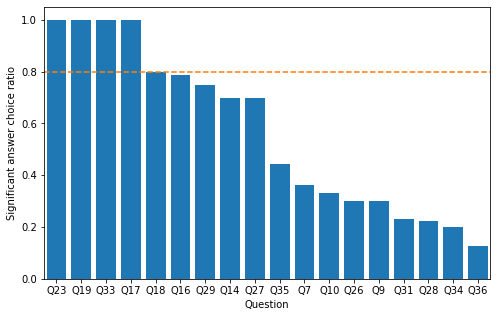

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))

plotRange   = [-0.5, len(ratio)-0.5]
ax.bar(ratio.index, ratio.values)
ax.hlines([0.8], plotRange[0], plotRange[1], colors=["tab:orange"], linestyles="dashed")
ax.set_xlim(plotRange)
ax.set_xlabel("Question")
ax.set_ylabel("Significant answer choice ratio")



In [36]:
selectedQuestions = ["Q17", "Q19", "Q23", "Q33"]

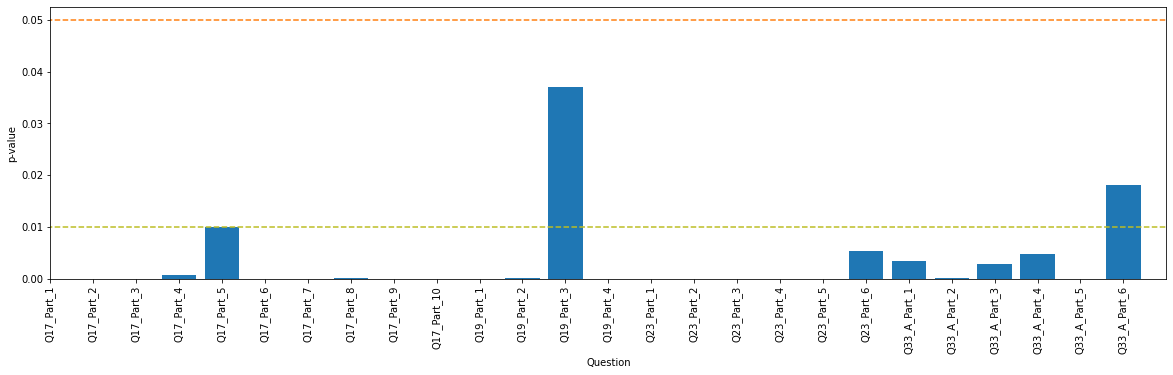

In [37]:
mwAnsSelected   = []
mwPSelected     = []

for question in selectedQuestions:
    count   = 0
    answerGroup = cleaned.filter(like=question)
    for answer in answerGroup:
        mwAnsSelected.append(answer)
        # mann-whitney's u test
        negMask     = cleaned[answer].isna()
        negSample   = cleaned.loc[negMask, "Q24_Encoded"]
        posSample   = cleaned.loc[~negMask, "Q24_Encoded"]
        U, p        = stats.mannwhitneyu(negSample, posSample)
        mwPSelected.append(p)

fig, ax = plt.subplots(figsize=(20, 5))
ax.bar(mwAnsSelected, mwPSelected)
ax.hlines([0.01, 0.05], -1, len(mwAnsSelected), colors=["tab:olive", "tab:orange"], linestyles="dashed")
ax.set_xlabel("Question")
ax.set_ylabel("p-value")
ax.set_xlim(0, len(mwAnsSelected))
ax.tick_params(axis='x', labelrotation=90)

In [38]:
from sklearn.utils import resample

def bootstrap(readSr):
    sizeSr          = len(readSr)
    bootstrapped    = pd.Series(index=range(sizeSr)).astype("float32")
    
    for i in range(sizeSr):
        bootstrapped[i] = np.mean(resample(readSr, n_samples = sizeSr))
#        bootstrapped[i] = np.median(resample(readSr, n_samples = sizeSr))
#        bootstrapped[i] = stats.mode(resample(readSr, n_samples = sizeSr))[0]

    return bootstrapped

In [39]:
from scipy.stats import lognorm

def plotDistSelectOrNot(question, answerChoice, figsize):
    answerGroup = cleaned.filter(like=question)
    nRow        = (len(answerGroup.columns) + 1)//2
    nCol        = 2 if 1 < len(answerGroup.columns) else 1

    fig, axes   = plt.subplots(nRow, nCol, 
                               figsize=figsize, 
                               tight_layout=True, 
                               sharey="row", sharex="col")

    for i in range(len(answerGroup.columns)):
        # determine ax position
        col = answerGroup.columns[i]
        roxIdx, colIdx  = i//2, i%2

        # plot histogram
        posMask = cleaned[col].notna()
        posSample   = cleaned.loc[posMask, "Q24_Encoded"]
        negSample   = cleaned.loc[~posMask, "Q24_Encoded"]

#        axes[roxIdx][colIdx].set_title("Answer choce %d" % (i + 1))
        axes[roxIdx][colIdx].set_title(answerChoice[i])
        axes[roxIdx][colIdx].hist([posSample, negSample], 
                                  label=["select", "not"], 
                                  color=["tab:blue", "tab:orange"], 
                                  density=True, bins=15)

        axes[roxIdx][colIdx].legend()

    for i in range(nRow):
        axes[i][0].set_ylabel("Density")

    for i in range(nCol):
        axes[nRow-1][i].set_xlabel("Salary buckets")

    figname = "salaryDist_" + question +".png"
    fig.savefig(figname)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


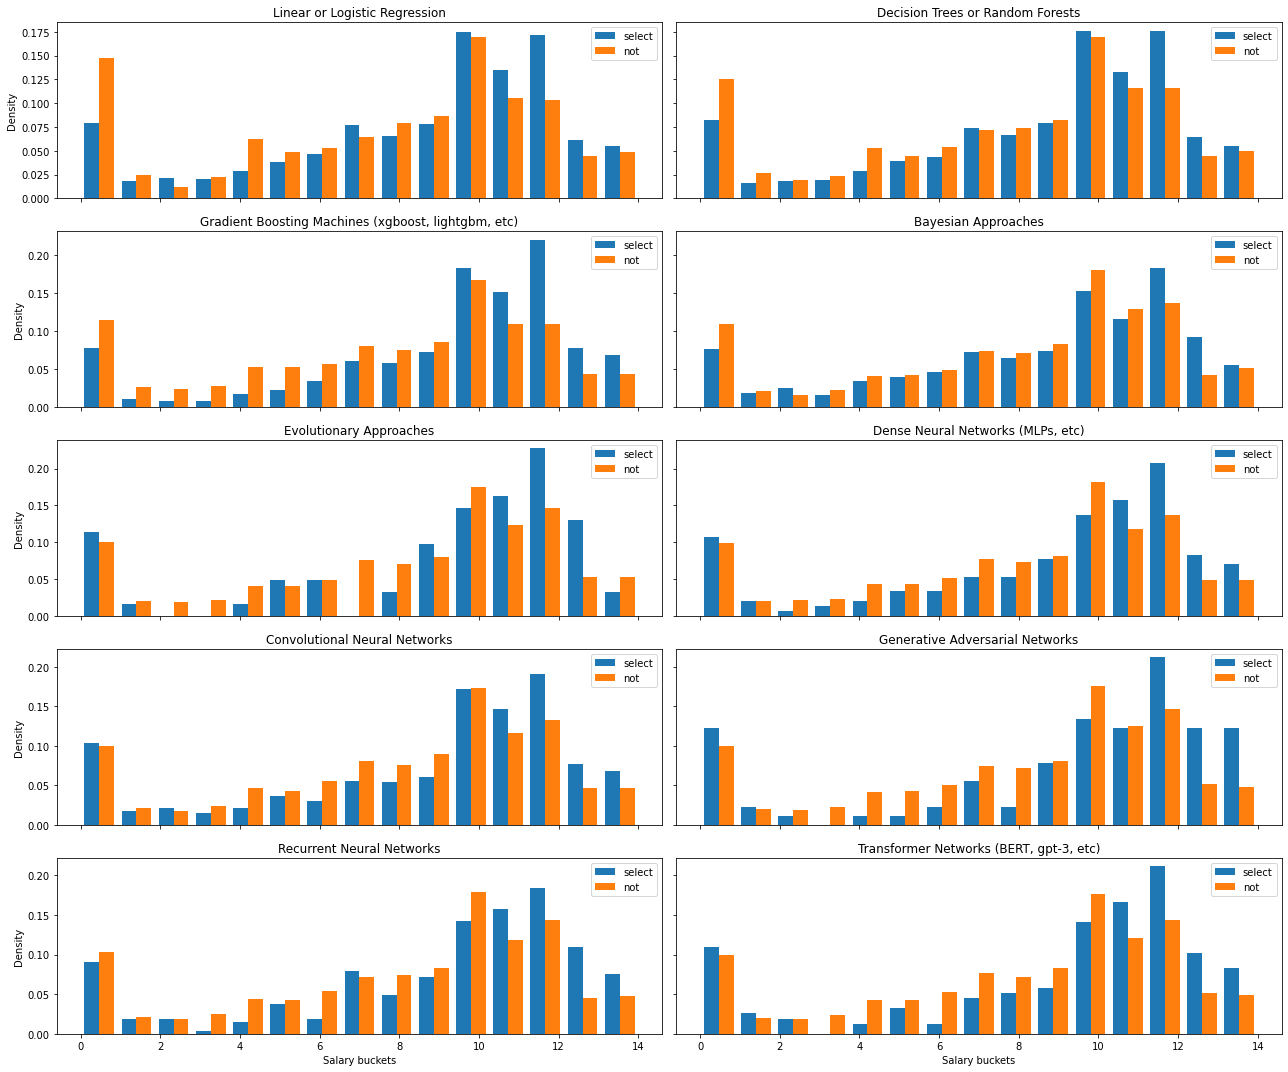

In [40]:
q17AnserChoice  = ["Linear or Logistic Regression", 
                   "Decision Trees or Random Forests", 
                   "Gradient Boosting Machines (xgboost, lightgbm, etc)", 
                   "Bayesian Approaches", 
                   "Evolutionary Approaches", 
                   "Dense Neural Networks (MLPs, etc)", 
                   "Convolutional Neural Networks",
                   "Generative Adversarial Networks", 
                   "Recurrent Neural Networks", 
                   "Transformer Networks (BERT, gpt-3, etc)"]

# Which of the following ML algorithms do you use on a regular basis?
plotDistSelectOrNot("Q17", q17AnserChoice, (18, 15))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


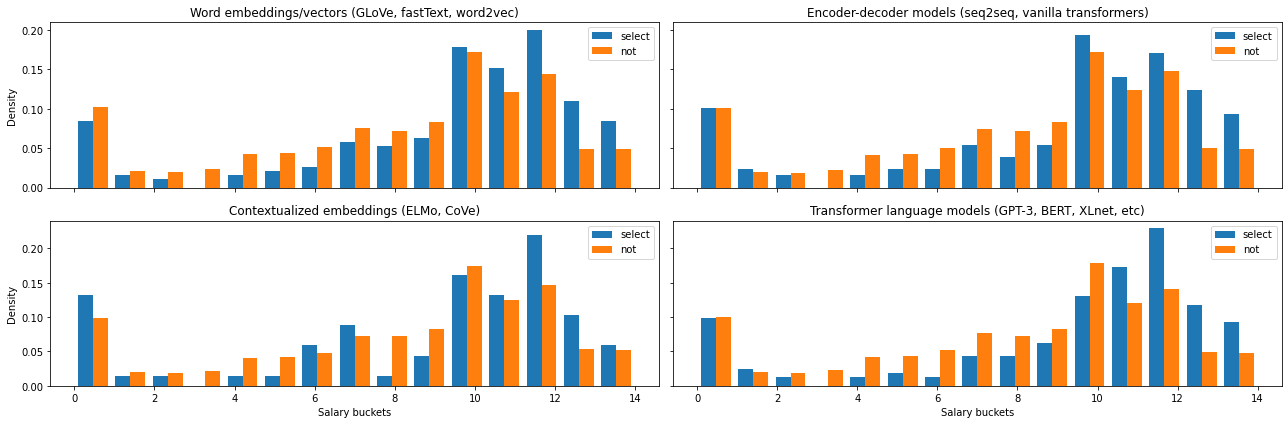

In [41]:
q19AnserChoice  = ["Word embeddings/vectors (GLoVe, fastText, word2vec)", 
                   "Encoder-decoder models (seq2seq, vanilla transformers)", 
                   "Contextualized embeddings (ELMo, CoVe)", 
                   "Transformer language models (GPT-3, BERT, XLnet, etc)"]
                   
# Which of the following natural language processing (NLP) methods do you use on a regular basis?
plotDistSelectOrNot("Q19", q19AnserChoice, (18, 6))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


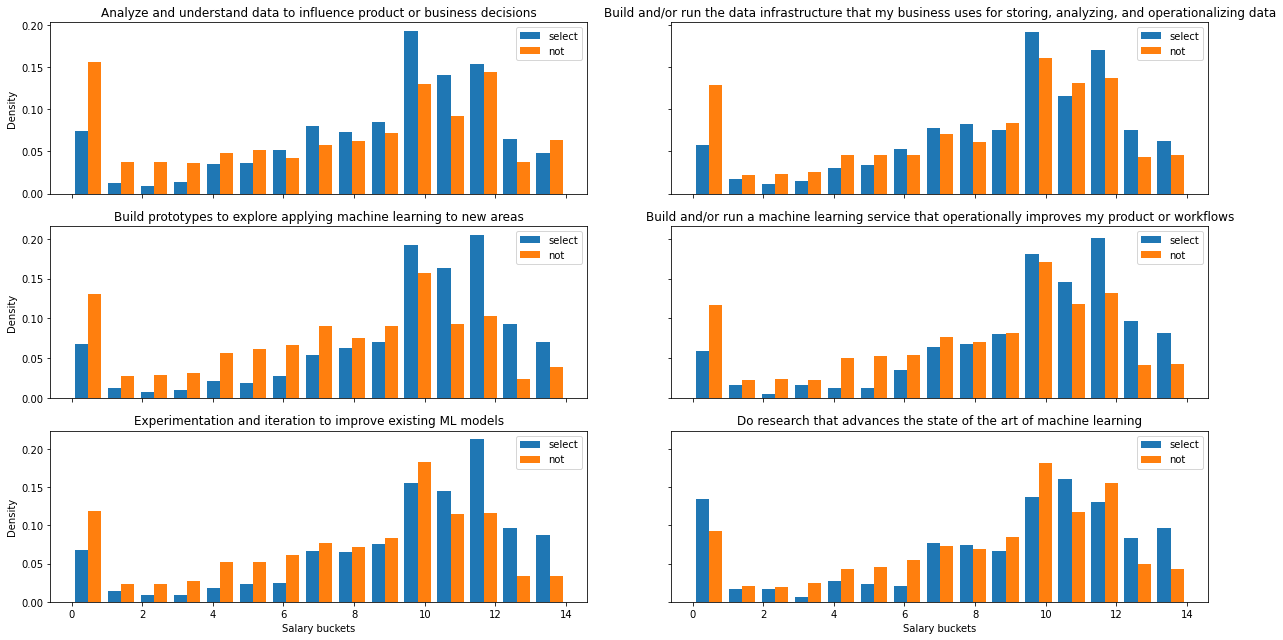

In [42]:
q23AnserChoice  = ["Analyze and understand data to influence product or business decisions", 
                   "Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data", 
                   "Build prototypes to explore applying machine learning to new areas", 
                   "Build and/or run a machine learning service that operationally improves my product or workflows", 
                   "Experimentation and iteration to improve existing ML models", 
                   "Do research that advances the state of the art of machine learning"]

# Select any activities that make up an important part of your role at work
plotDistSelectOrNot("Q23", q23AnserChoice, (18, 9))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


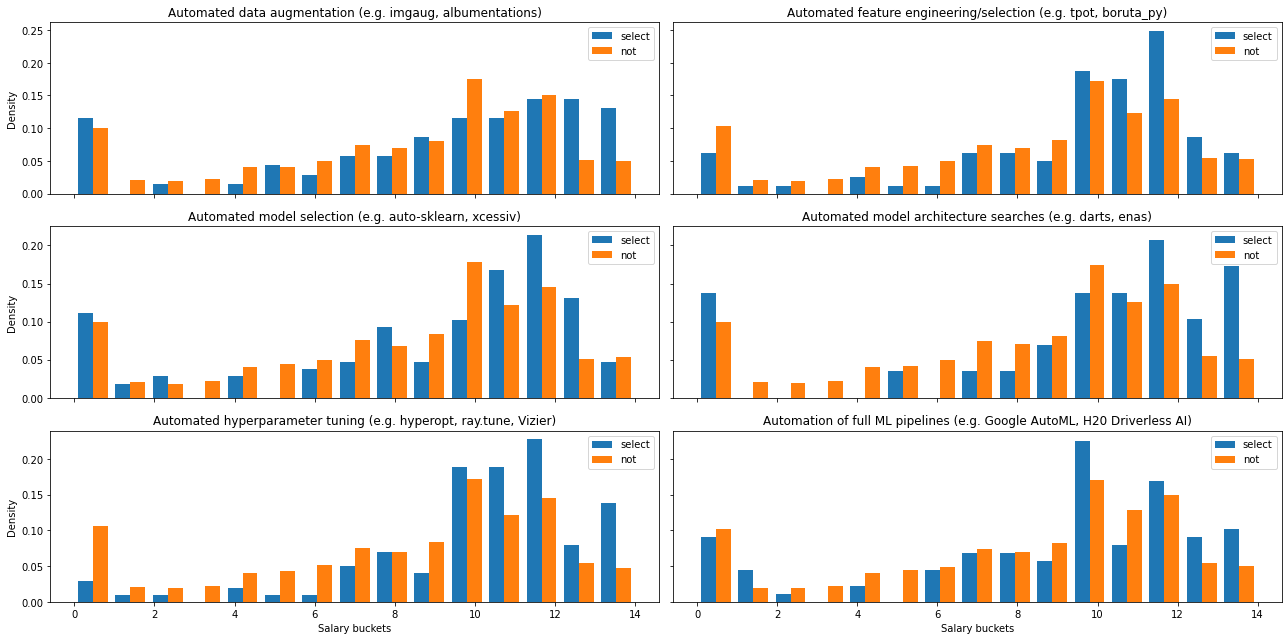

In [43]:
q33AnserChoice  = ["Automated data augmentation (e.g. imgaug, albumentations)", 
                   "Automated feature engineering/selection (e.g. tpot, boruta_py)", 
                   "Automated model selection (e.g. auto-sklearn, xcessiv)", 
                   "Automated model architecture searches (e.g. darts, enas)", 
                   "Automated hyperparameter tuning (e.g. hyperopt, ray.tune, Vizier)", 
                   "Automation of full ML pipelines (e.g. Google AutoML, H20 Driverless AI)"] 
                   
# Which of the following machine learning frameworks do you use on a regular basis?
plotDistSelectOrNot("Q33", q33AnserChoice, (18, 9))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


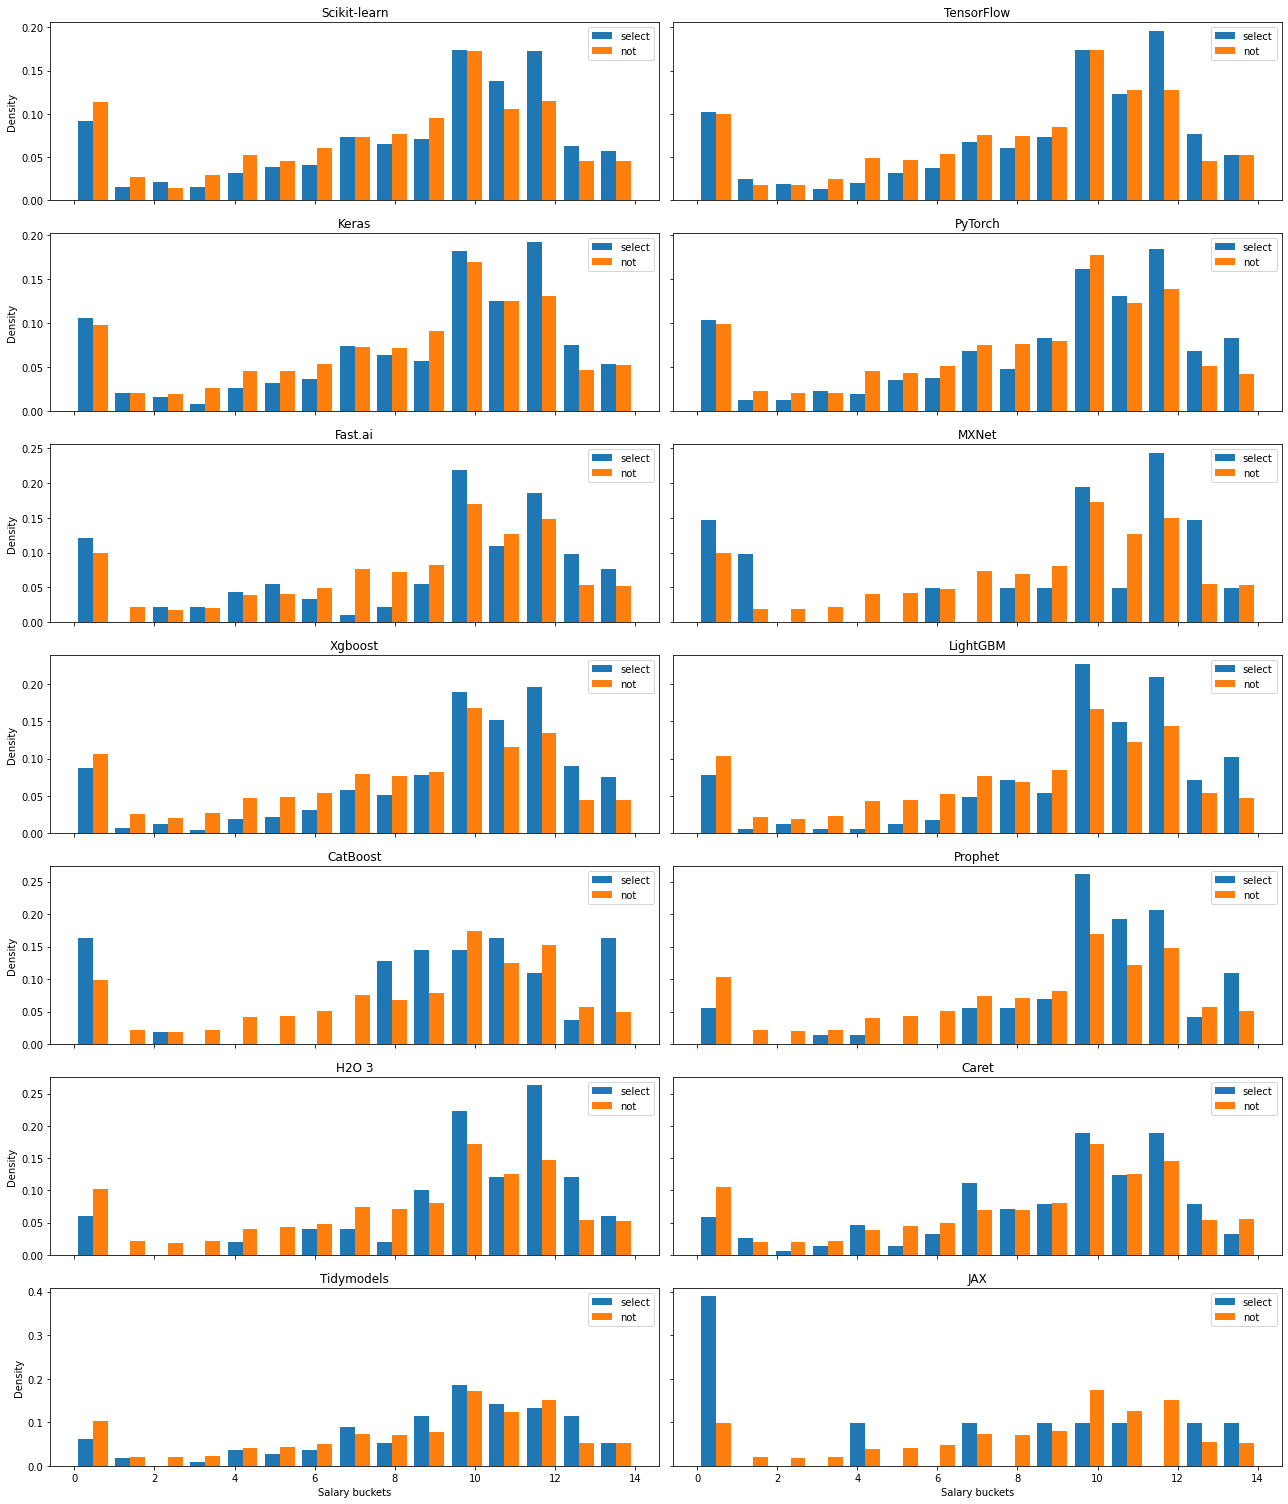

In [44]:
q16AnserChoice  = ["Scikit-learn", 
                   "TensorFlow", 
                   "Keras", 
                   "PyTorch", 
                   "Fast.ai", 
                   "MXNet", 
                   "Xgboost", 
                   "LightGBM", 
                   "CatBoost", 
                   "Prophet", 
                   "H2O 3", 
                   "Caret", 
                   "Tidymodels", 
                   "JAX"] 
                   
# Which of the following machine learning frameworks do you use on a regular basis?
plotDistSelectOrNot("Q16", q16AnserChoice, (18, 21))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


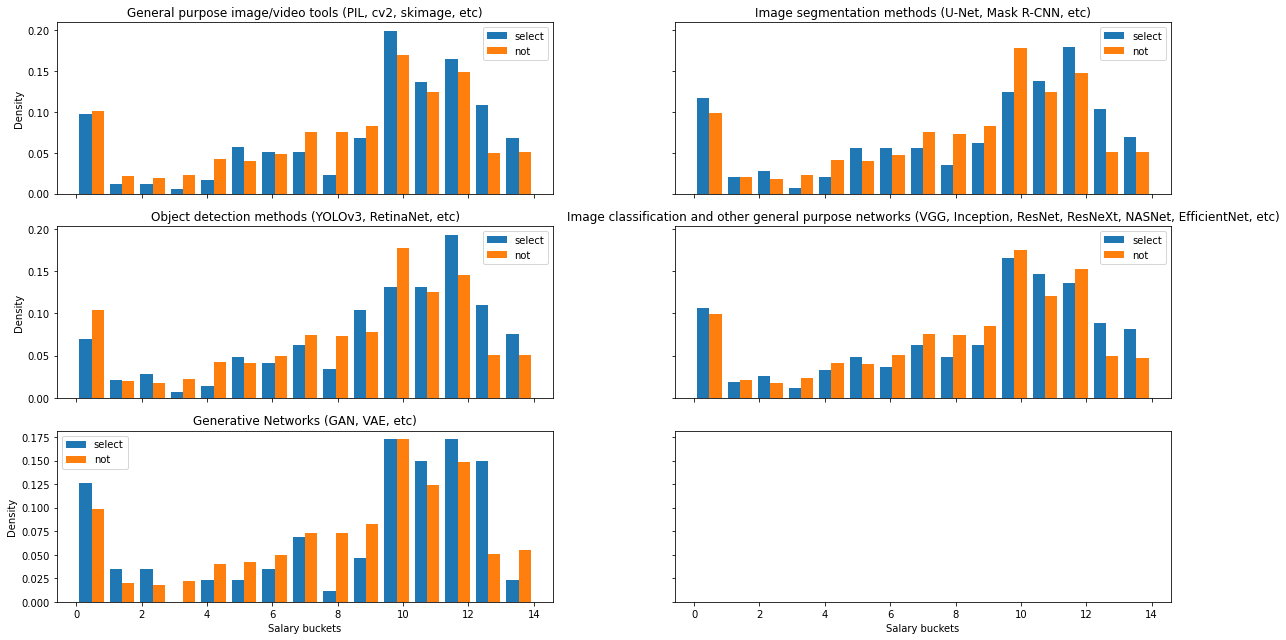

In [45]:
q18AnserChoice  = ["General purpose image/video tools (PIL, cv2, skimage, etc)", 
                   "Image segmentation methods (U-Net, Mask R-CNN, etc)",
                   "Object detection methods (YOLOv3, RetinaNet, etc)", 
                   "Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)", 
                   "Generative Networks (GAN, VAE, etc)"]

# Which of the following machine learning frameworks do you use on a regular basis?
plotDistSelectOrNot("Q18", q18AnserChoice, (18, 9))